In [5]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import os

# Set up matplotlib for better display in notebooks
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6) # Make plots wider

# --- Configuration ---
# Point this to your test video in the data directory
VIDEO_PATH = "../data/test_match1.mp4" 
AUDIO_CACHE_PATH = "../data/temp_match_audio.wav"

## Extract and save audio from the video file

In [6]:
# Check if the audio file already exists to save time
if not os.path.exists(AUDIO_CACHE_PATH):
    print("Extracting audio from video... This might take a moment.")
    with VideoFileClip(VIDEO_PATH) as video:
        video.audio.write_audiofile(AUDIO_CACHE_PATH)
    print(f"Audio extracted and saved to {AUDIO_CACHE_PATH}")
else:
    print(f"Using cached audio file from {AUDIO_CACHE_PATH}")

Extracting audio from video... This might take a moment.
MoviePy - Writing audio in ../data/temp_match_audio.wav


MoviePy - Done.
Audio extracted and saved to ../data/temp_match_audio.wav


## Load Audio and Compute Onset Strength

In [7]:
print("Loading audio and computing onset strength...")
# Load the audio time series (y) and its sampling rate (sr)
y, sr = librosa.load(AUDIO_CACHE_PATH)

# Define the hop_length for STFT. 512 is a good default.
hop_length = 512

# Compute the onset strength envelope
onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)

print("Onset strength envelope computed.")
print(f"Shape of onset_env: {onset_env.shape}")

Loading audio and computing onset strength...
Onset strength envelope computed.
Shape of onset_env: (607,)


## Visualize the Onset Strength Envelope

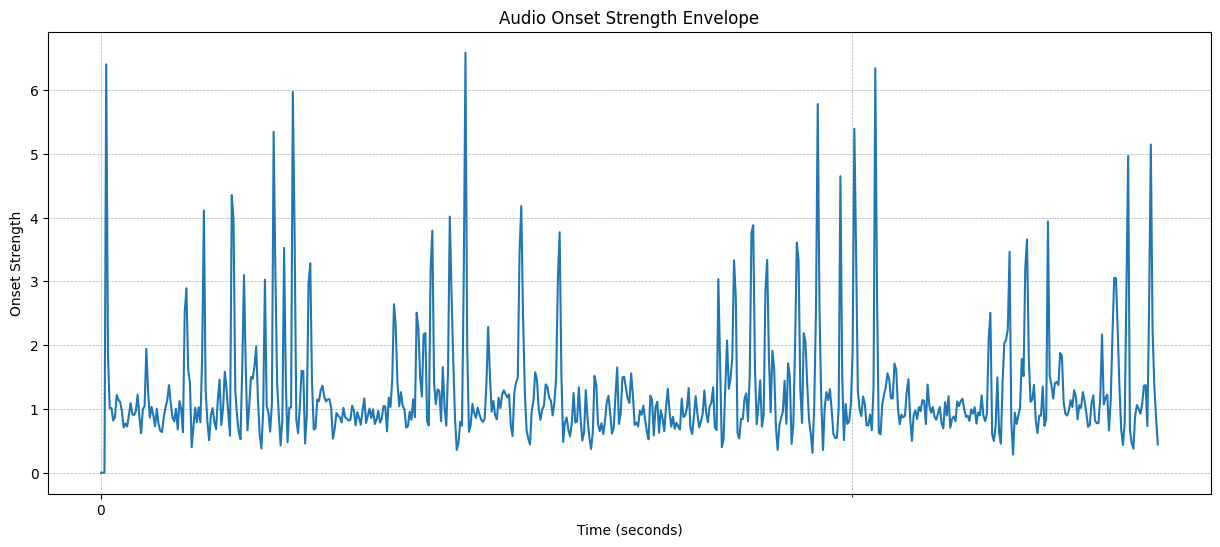

In [8]:
# --- Updated Visualization with Finer Time Intervals ---

# Create a time axis for the x-axis of our plot
times = librosa.times_like(onset_env, sr=sr, hop_length=hop_length)

# Get the figure and axes objects for more control
fig, ax = plt.subplots()

# Plot the envelope on the axes
ax.plot(times, onset_env)
ax.set_title('Audio Onset Strength Envelope')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Onset Strength')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# --- NEW: Code to control the x-axis ticks ---
from matplotlib.ticker import MultipleLocator

# Set major ticks every 50 seconds
ax.xaxis.set_major_locator(MultipleLocator(50)) 

# Set minor ticks every 10 seconds for even finer detail
ax.xaxis.set_minor_locator(MultipleLocator(10)) 

# Optional: Make the plot easier to read by setting x-axis limits
# This zooms in on the first 10 minutes of the match for example
# ax.set_xlim(0, 600) 

plt.show()

## Peak Detection and Tuning (The Interactive Part)

Detected 3 peaks.
Peak timestamps (seconds):
[ 4.85 10.31 13.98]


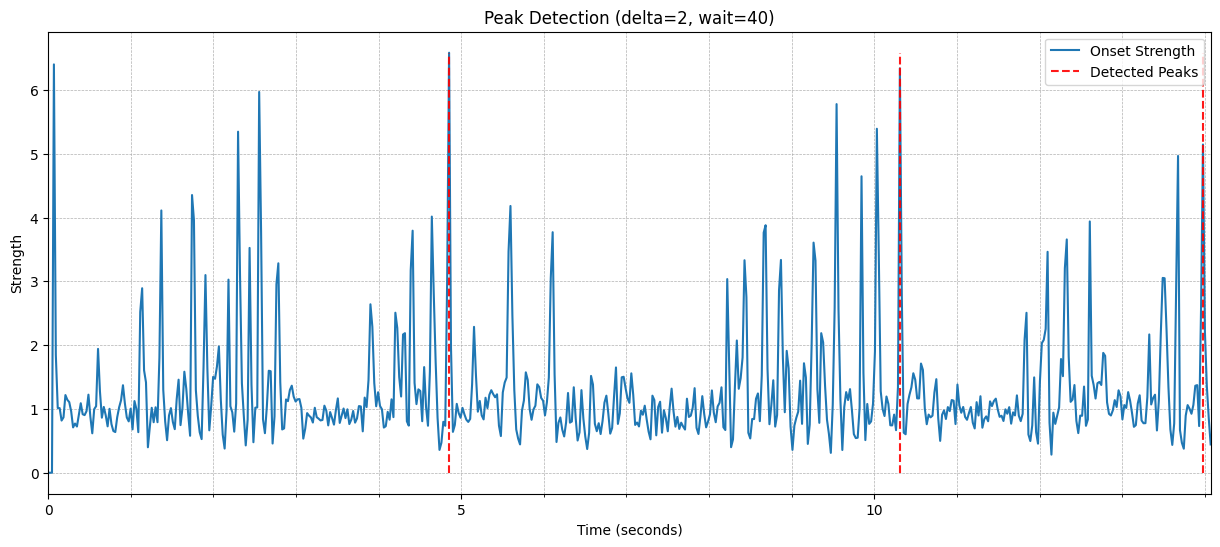

In [14]:

plt.show()# --- Your Tuned Parameters ---
# NOTE: These parameters might be very large for a 40-second video.
# A 'wait' of 560 frames is ~13 seconds, meaning only one peak can be
# found every 13 seconds. This might be what you want (to find only the ONE biggest event).
PEAK_DELTA = 2
PEAK_WAIT = 40
# --------------------------

# Detect the peaks
peaks = librosa.util.peak_pick(
    onset_env,
    pre_max=40,
    post_max=800,
    pre_avg=7,
    post_avg=7,
    delta=PEAK_DELTA,
    wait=PEAK_WAIT
)

# Convert peak frames to timestamps
peak_times = librosa.frames_to_time(peaks, sr=sr, hop_length=hop_length)

print(f"Detected {len(peaks)} peaks.")
print("Peak timestamps (seconds):")
print(np.round(peak_times, 2))


# --- Visualize the results, OPTIMIZED for short videos (<= 40s) ---
fig, ax = plt.subplots()

ax.plot(times, onset_env, label='Onset Strength')
ax.vlines(peak_times, 0, onset_env.max(), color='r', alpha=0.9, linestyle='--', label='Detected Peaks')
ax.set_title(f'Peak Detection (delta={PEAK_DELTA}, wait={PEAK_WAIT})')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Strength')
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# --- MODIFIED: Code to control the x-axis ticks for short videos ---
from matplotlib.ticker import MultipleLocator

# Set major ticks every 5 seconds. This will give you clear labels.
ax.xaxis.set_major_locator(MultipleLocator(5)) 

# Set minor ticks every 1 second for maximum detail.
ax.xaxis.set_minor_locator(MultipleLocator(1)) 

# --- MODIFIED & IMPORTANT: Automatically set the x-axis limit ---
# This makes the plot fit the exact duration of your video perfectly.
# No more empty space.
if times.any():
    ax.set_xlim(0, times.max()) 

plt.show()

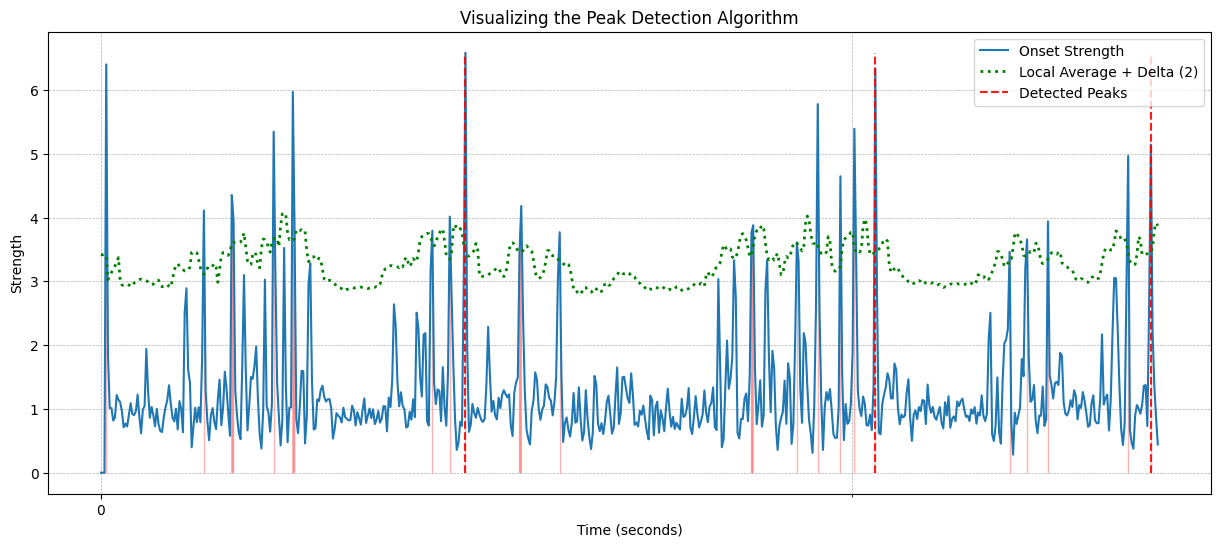

In [15]:
# --- Let's visualize what the algorithm is actually doing (with Finer Ticks) ---

from scipy.ndimage import uniform_filter1d
from matplotlib.ticker import MultipleLocator

avg_window_size = 7 + 7 + 1 
local_average = uniform_filter1d(onset_env, size=avg_window_size)
threshold_line = local_average + PEAK_DELTA

# --- Plot everything together ---
fig, ax = plt.subplots()

ax.plot(times, onset_env, label='Onset Strength')
ax.plot(times, threshold_line, color='g', linestyle=':', linewidth=2, label=f'Local Average + Delta ({PEAK_DELTA})')
ax.vlines(peak_times, 0, onset_env.max(), color='r', alpha=0.9, linestyle='--', label='Detected Peaks')

ax.set_title('Visualizing the Peak Detection Algorithm')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Strength')
ax.legend()
ax.fill_between(times, 0, onset_env, where=onset_env > threshold_line, color='r', alpha=0.3, label='Regions Above Threshold')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# --- NEW: Code to control the x-axis ticks ---
ax.xaxis.set_major_locator(MultipleLocator(50)) # Major ticks every 50 seconds
ax.xaxis.set_minor_locator(MultipleLocator(10)) # Minor ticks every 10 seconds

plt.show()